<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_3_LLM/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Supervised Learning for Text Summarization

## Business Understanding

### Background

### Dataset Details

### Project Goals

### Project Considerations

In [21]:
!pip uninstall -y transformers
!pip uninstall -y huggingface_hub
!pip install -U transformers


Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: huggingface-hub 0.33.4
Uninstalling huggingface-hub-0.33.4:
  Successfully uninstalled huggingface-hub-0.33.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 469.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 35.6 MB/s eta 0:00:00


## Data Understanding

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, \
  accuracy_score, ConfusionMatrixDisplay
from transformers import BertTokenizer, EncoderDecoderModel, TrainingArguments,\
  Trainer, DataCollatorForSeq2Seq
import transformers

# set random seed for reproducibility
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [2]:
# install hugging face
# !pip install datasets

In [3]:
# load samsum dataset
from datasets import load_dataset

dataset = load_dataset('knkarthick/samsum')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [5]:
print(dataset['train'][0])

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


In [6]:
# convert train, validation and test datasets to dataframes for EDA
# pandas dfs are better for quick exploration than Hugging Face datasets
# hugging face dataset objects are good for modeling, but less flexible for:
# describe(), filtering, plotting, sample inspection

df_train = pd.DataFrame(dataset['train'])
print(df_train.head())

df_val = pd.DataFrame(dataset['validation'])
print(df_val.head())

df_test = pd.DataFrame(dataset['test'])
print(df_test.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  
         id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\nJackie: but she d...   
3  138196

### Text Exploration
Analyze the characteristics of the dialogues and summaries

In [7]:
# train df basic info and describe
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14731 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB
None
              id                                           dialogue  \
count      14732                                              14731   
unique     14732                                              14255   
top     13729017  Jimmy: Hey, guess what? My car's completely ka...   
freq           1                                                  4   

                                                  summary  
count                                               14732  
unique                                              14730  
top     Seth's pet Oreo that he got when he was 10 is ...  
freq                                                    2  

In [8]:
# length of train df
print(f"Length of train df: {len(df_train)}")

Length of train df: 14732


In [9]:
# text length analysis
# analysis will include speaker names
df_train['dialogue_length'] = df_train['dialogue'].apply(lambda x: len(str(x).split()))
print(f"\nAverage dialogue length: {df_train['dialogue_length'].mean():.2f} words")
print(f"\nMedian dialogue length: {df_train['dialogue_length'].median():.2f} words")
print(f"\nMinimum dialogue length: {df_train['dialogue_length'].min()} words")
print(f"\nMaximum dialogue length: {df_train['dialogue_length'].max()} words")


Average dialogue length: 93.79 words

Median dialogue length: 73.00 words

Minimum dialogue length: 1 words

Maximum dialogue length: 803 words


In [10]:
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))
print(f"\nAverage summary length: {df_train['summary_length'].mean():.2f} words")
print(f"\nMedian summary length: {df_train['summary_length'].median():.2f} words")
print(f"\nMinimum summary length: {df_train['summary_length'].min()} words")
print(f"\nMaximum summary length: {df_train['summary_length'].max()} words")


Average summary length: 20.32 words

Median summary length: 18.00 words

Minimum summary length: 1 words

Maximum summary length: 64 words


In [11]:
# check for missing values
print(df_train.isnull().sum())
print(df_val.isnull().sum())
print(df_test.isnull().sum())

id                 0
dialogue           1
summary            0
dialogue_length    0
summary_length     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64
id          0
dialogue    0
summary     0
dtype: int64


In [12]:
# drop row from df_train with missing value in dialogue column
df_train = df_train.dropna(subset=['dialogue'])
print(df_train.isnull().sum())
print(f"\nLength of train df: {len(df_train)}")

id                 0
dialogue           0
summary            0
dialogue_length    0
summary_length     0
dtype: int64

Length of train df: 14731


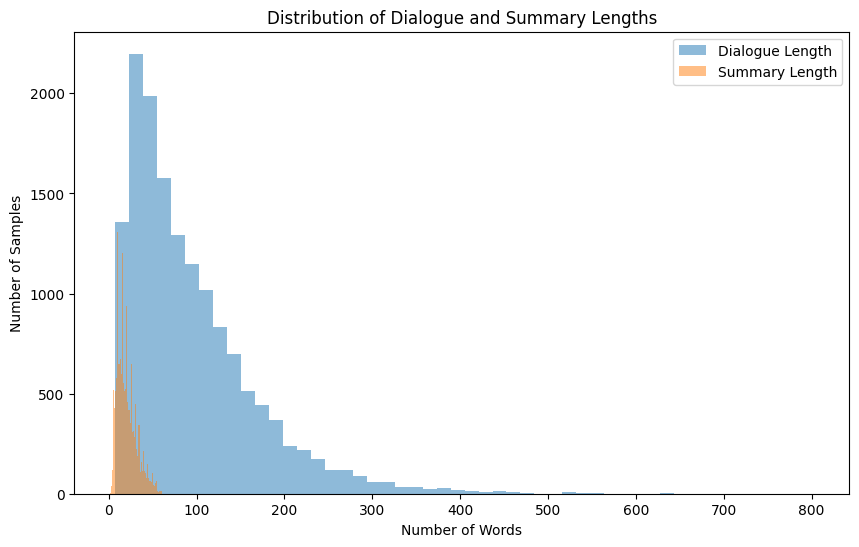

In [13]:
# plot dialogue vs summary lengths
plt.figure(figsize=(10, 6))
plt.hist(df_train['dialogue_length'], bins=50, alpha=0.5, label='Dialogue Length')
plt.hist(df_train['summary_length'], bins=50, alpha=0.5, label='Summary Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dialogue and Summary Lengths')
plt.legend()
plt.show()

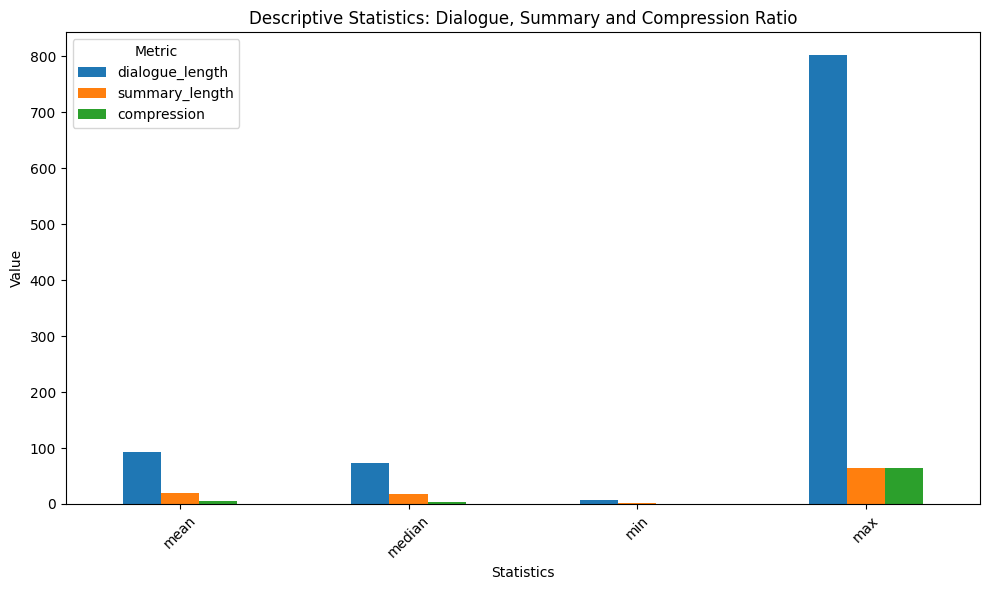

In [14]:
# plot dialogue, summary, and compression statistics
df_train['compression'] = df_train['dialogue_length'] / df_train['summary_length']
stats = df_train[['dialogue_length', 'summary_length', 'compression']].agg(['mean', 'median', 'min', 'max']).round(2).T

# plot statistics
stats.T.plot(kind='bar', figsize=(10,6))
plt.title('Descriptive Statistics: Dialogue, Summary and Compression Ratio')
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [15]:
# examples of dialogue and summary
print(f"\nDialogue: {df_train['dialogue'][5]}")
print(f"\nSummary: {df_train['summary'][5]}")

print(f"\nDialogue: {df_train['dialogue'][1000]}")
print(f"\nSummary: {df_train['summary'][1000]}")


Dialogue: Neville: Hi there, does anyone remember what date I got married on?
Don: Are you serious?
Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.
Wyatt: Hang on, I'll ask my wife.
Don: Haha, someone's in a lot of trouble :D
Wyatt: September 17. I hope you remember the year ;)

Summary: Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.

Dialogue: Ann: Do you have plans for the holidays this year?
Mary: Well we thought of going for a hike somewhere beautiful
Mary: and you?
Ann: We talked about it last night and we thought maybe you would like to do sth together?
Mary: Why not
Mary: just remember that we're outdoorsy people :D
Ann: I know, but you're not even considering a nice beach somewhere?
Mary: weeeeell, that's not r

## Data Preparation

Prep data for input to BERT model
* implement appropriate tokenization
* create training and validation splits
* build data loaders for efficient model training

In [16]:
# initialize tokenizer
# converts input dialogue into token IDs for the encoder
# converts target summary into token IDs for the decoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_INPUT_LENGTH = 512
MAX_TARGET_LENGTH = 64

# define tokenize function
def tokenize_function(batch):

  # tokenize input dialogue
  inputs = tokenizer(
      batch['dialogue'],
      padding='max_length',
      truncation=True,
      max_length = MAX_INPUT_LENGTH,
  )

  # tokenize target summary
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        batch['summary'],
        padding='max_length',
        truncation=True,
        max_length=MAX_TARGET_LENGTH,
  )

  # attach labels to inputs
  inputs['labels'] = labels['input_ids']
  return inputs

In [17]:
# tokenize train, validation, and test datasets

start_time = time.time()

# Remove examples with None in 'dialogue' or 'summary'
dataset['train'] = dataset['train'].filter(lambda x: x['dialogue'] is not None and x['summary'] is not None)

tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_val = dataset['validation'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

end_time = time.time()
print(f"Tokenization time: {end_time - start_time:.2f} seconds")

# Tokenization time: 50 sec on 7/25/25

Tokenization time: 0.79 seconds


In [18]:
# load a BERT2BERT pre-trained model (encoder-decoder)
# use patrickvonplaten/bert2bert-cnn_dailymail-fp16 as a BERT2BERT model fine-tuned on CNN/DailyMail
# encoder and decoder both use bert-case-uncased
# bert-case-uncased is a commonly used pretrained BERT model from the original BERT paper

model = EncoderDecoderModel.from_pretrained('patrickvonplaten/bert2bert-cnn_dailymail-fp16')

Some weights of the model checkpoint at patrickvonplaten/bert2bert-cnn_dailymail-fp16 were not used when initializing EncoderDecoderModel: ['decoder.bert.pooler.dense.bias', 'decoder.bert.pooler.dense.weight']
- This IS expected if you are initializing EncoderDecoderModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EncoderDecoderModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# configure the model for the summarization task
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

## Modeling

In [20]:
# set up training arguments

training_args = TrainingArguments(
    output_dir="./bert2bert_samsum",
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    logging_steps=500,
    save_steps=1000,
    eval_steps=1000,
    num_train_epochs=3,
    save_total_limit=2,
    fp16=True  # if using GPU
)


data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
print(transformers.__version__)

## Evaluation

# Conclusion